# CNN to classify images of rice based on 5 labels. Each label is a different kind of rice.

In [ ]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from keras import mixed_precision, regularizers
from keras.callbacks import EarlyStopping
mixed_precision.set_global_policy('mixed_float16')


In [ ]:
'''
Switching dataset from pokemon to rice image dataste. Need to take form kaggle and move all images into training/valid/testing sets.
'''

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 128
SEED = 123

'''
base_path = Path(path)

for path in base_path.iterdir():
    if path.is_dir():
        print(path)
'''

dataset_path = Path(path) / 'Rice_Image_Dataset'

train_images = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split = 0.30,
    subset = 'training',
    seed = SEED,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE
)

valid_test_images = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split = 0.30,
    subset = 'validation',
    seed = SEED,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE
)

valid_size = int(0.5*valid_test_images.cardinality().numpy())
valid_images = valid_test_images.take(valid_size)
test_images = valid_test_images.skip(valid_size)

Using Colab cache for faster access to the 'rice-image-dataset' dataset.
Path to dataset files: /kaggle/input/rice-image-dataset
Found 75000 files belonging to 5 classes.
Using 52500 files for training.
Found 75000 files belonging to 5 classes.
Using 22500 files for validation.


In [ ]:
for image, label in train_images.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label Shape: {label.shape}")

Image shape: (128, 128, 128, 3)
Label Shape: (128,)


In [ ]:
# Check image Pixel Range to see if normalization is needed - [0, 255] means normalization needed, [0, 1] means normalized
for images, labels in train_images.take(1):
    batch_images = images
    batch_labels = labels

print(f'Pixel Min: {np.min(batch_images)}')
print(f'Pixel Max: {np.max(batch_images)}')

print(f'Labels: {batch_labels.numpy()}')

Pixel Min: 0.0
Pixel Max: 255.0
Labels: [4 4 1 3 1 3 4 1 1 1 1 4 1 2 1 0 1 0 3 2 4 0 0 1 0 2 1 3 3 1 4 3 1 4 4 3 4
 1 3 0 0 4 1 0 4 3 1 2 3 4 3 0 1 4 1 1 0 0 3 4 1 1 0 1 1 1 4 4 4 0 0 4 2 0
 4 0 0 2 3 1 2 4 2 1 2 4 0 4 2 2 0 0 4 0 2 1 0 3 0 1 0 2 1 1 1 0 4 4 1 0 2
 4 1 0 0 2 3 2 3 1 3 4 0 1 1 3 0 0]


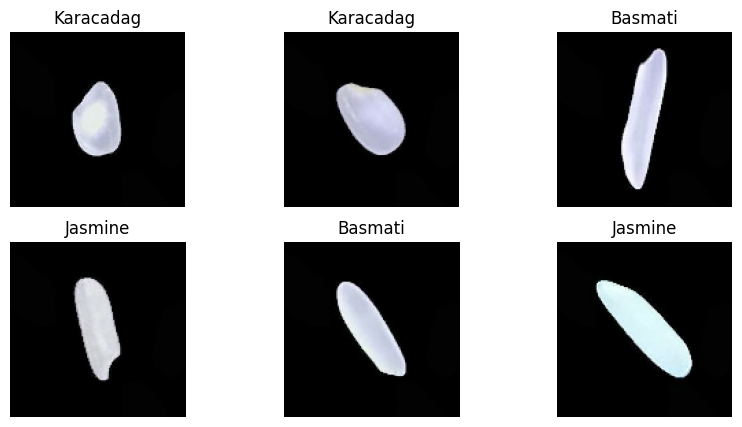

In [ ]:
# Code to check if labels match the images for first batch
import matplotlib.pyplot as plt

class_names = train_images.class_names

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.title(class_names[batch_labels[i]])
    plt.axis("off")
plt.show()


In [ ]:
# normalize pixel values to [0.0, 1.0] by casting to float
train_images = train_images.map(lambda images, labels: (tf.cast(images, tf.float32) / 255.0, labels))

test_images = test_images.map(lambda images, labels: (tf.cast(images, tf.float32) / 255.0, labels))

valid_images = valid_images.map(lambda images, labels: (tf.cast(images, tf.float32) / 255.0, labels))


In [ ]:
model = Sequential()
# Data Augmentation to increase number of images CNN sees
model.add(RandomFlip('horizontal'))
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.15))
model.add(RandomTranslation(0.1, 0.1))
model.add(RandomContrast(0.1))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape = (IMG_WIDTH,IMG_HEIGHT, 3), kernel_regularizer=regularizers.L2(.001)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.L2(.001)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.L2(.001)))
model.add(MaxPooling2D(2,2))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.L2(.001)))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation = 'softmax'))

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True,
    mode = 'auto'
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.layers

[<RandomFlip name=random_flip_4, built=False>,
 <RandomRotation name=random_rotation_4, built=False>,
 <RandomZoom name=random_zoom_4, built=False>,
 <RandomTranslation name=random_translation_4, built=False>,
 <RandomContrast name=random_contrast_4, built=False>,
 <Conv2D name=conv2d_11, built=False>,
 <MaxPooling2D name=max_pooling2d_11, built=True>,
 <Conv2D name=conv2d_12, built=False>,
 <MaxPooling2D name=max_pooling2d_12, built=True>,
 <Conv2D name=conv2d_13, built=False>,
 <MaxPooling2D name=max_pooling2d_13, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_4, built=True>,
 <Dense name=dense_8, built=False>,
 <Dropout name=dropout_4, built=True>,
 <Dense name=dense_9, built=False>]

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_4            │ ?                      │   0 (unbuilt) │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ ?                      │   0 (unbuilt) │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_images, epochs=100, validation_data=valid_images, callbacks = [early_stopping])

Epoch 1/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 144ms/step - accuracy: 0.3877 - loss: 1.3930 - val_accuracy: 0.7650 - val_loss: 0.7949
Epoch 2/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 60s 146ms/step - accuracy: 0.6824 - loss: 0.8804 - val_accuracy: 0.6996 - val_loss: 0.7398
Epoch 3/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - accuracy: 0.8268 - loss: 0.5958 - val_accuracy: 0.7577 - val_loss: 0.6192
Epoch 4/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 58s 140ms/step - accuracy: 0.8777 - loss: 0.4796 - val_accuracy: 0.5373 - val_loss: 1.2321
Epoch 5/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - accuracy: 0.8919 - loss: 0.4411 - val_accuracy: 0.8358 - val_loss: 0.4861
Epoch 6/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.9005 - loss: 0.4063 - val_accuracy: 0.5993 - val_loss: 1.1090
Epoch 7/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.9040 - loss: 0.4024 - val_accuracy: 0.6879 - val_loss: 0.8862
Epoch 8/100
411/411 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.9194 -

In [ ]:
# Test the model to check if over/underfit
test_loss, test_acc = model.evaluate(test_images)
print(f'Test accuracy: {test_acc}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.9870 - loss: 0.1412
Test accuracy: 0.9881630539894104
